# Part 4 - Gradient Descent 

In this section, we will use the linear regression model, which we have learned in the tutorial, to do predictions based on our dataset. First, we will apply a gradient descent algorithmn to optimize the parameters of the predictive funtion. Second, we will explore the tuning of different hyperparameters in the model. Finally, we will try some advanced optimisation techniques to improve our results.

__Overview of Implementation__ <a class="anchor" id="top"></a>
1. [Import](#import)
2. [Cleaning the Data for Model Training](#clean)
3. [Gradient Descent function](#gd)
5. [Reducing Dimension: Feature selection](#feature)
6. [Hyperparameter Tuning 1](#hyper1)
  1. [Polynomial Degree](#poly)
7. [Regularisation](#reg)
8. [Hyperparameter Tuning 2 - with K-fold Cross Validation](#hyper2)
  1. [Regularisation Parameter](#Kreg)
  2. [Learning Rate](#Ktau)
  3. [Initial w](#Kw)
  4. [Results](#Kresults)
9. [Advanced Optimisation Techniques](#adv)
  1. [Keras TensorFlow](#keras)
    1. [Adam](#kerasadam)
    2. [Nadam](#kerasnadam)
  2. [MLP Regressor](#mlp)
    1. [Adam](#SKadam)
    2. [Limited-memory BFGS](#SKLBFGS)
  3. [Submitting to Kaggle](#submit)


In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import researchpy as rp
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statistics import mean, median, mode, stdev
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from scipy.stats import skew 


## Import <a class="anchor" id="import"></a>

In [2]:
train = pd.read_csv('train.csv')
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


## Cleaning the Data for Model Training <a class="anchor" id="clean"></a>
For the pre-processing, we will remove the null data and highly skewed categorical variables.<br>
Then, we will perform One Hot Encoding. 

In [3]:
nullData = [['LotFrontage', 259], ['MasVnrArea', 8], ['Electrical', 1], ['GarageYrBlt', 81]]
n = len(train)
treshold = 0.1
drop = []

print('Drop feature - too many nulls:')
for i in nullData:
    if i[1]/n > treshold: # Arbitrary treshold: 10%
        print(i[0])
        train.drop(columns=[i[0]], inplace=True)
    else:
        drop.append(i[0])
        
print('Remove data point:')
print(drop)
train.dropna(subset=drop, inplace=True)

train

Drop feature - too many nulls:
LotFrontage
Remove data point:
['MasVnrArea', 'Electrical', 'GarageYrBlt']


,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [4]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
#skewness of categorical variables
max_percent = []
catogorical_skewed=[]
for i in categorical: 
    if rp.summary_cat(train[i])["Percent"].max() >= 90: 
        max_percent.append(rp.summary_cat(train[i])["Percent"].max())
print ("The number of variables with one category of data which occupies >= 90% of data =", len(max_percent))
#highly skewed categorical variables
for i in categorical: 
    if rp.summary_cat(train[i])["Percent"].max() >= 90:
        catogorical_skewed.append(i)
        print (i,"/ratio of the dominant category = ", rp.summary_cat(train[i])["Percent"].max()/100)
train.drop(columns=catogorical_skewed, inplace=True)

The number of variables with one category of data which occupies >= 90% of data = 15
Street /ratio of the dominant category =  0.9964
LandContour /ratio of the dominant category =  0.9015000000000001
Utilities /ratio of the dominant category =  0.9993000000000001
LandSlope /ratio of the dominant category =  0.9467
Condition2 /ratio of the dominant category =  0.9898
RoofMatl /ratio of the dominant category =  0.9818000000000001
BsmtCond /ratio of the dominant category =  0.9246
Heating /ratio of the dominant category =  0.981
CentralAir /ratio of the dominant category =  0.9495999999999999
Electrical /ratio of the dominant category =  0.9226000000000001
Functional /ratio of the dominant category =  0.9336
GarageQual /ratio of the dominant category =  0.9504
GarageCond /ratio of the dominant category =  0.9612999999999999
PavedDrive /ratio of the dominant category =  0.9372
MiscFeature /ratio of the dominant category =  0.9216


In [5]:
#One-Hot encoding
categoricalcolumns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
remaining_cat_col=[]
for i in categoricalcolumns:
    if i not in catogorical_skewed: 
        remaining_cat_col.append(i)
train1 = pd.get_dummies(train, columns= remaining_cat_col, prefix= remaining_cat_col)
train1

,Id,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,8450,2003,2003,196.0,706,0,150,856,856,...,0,0,0,1,0,0,0,0,1,0
1,2,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,0,0,1,0,0,0,0,1,0
2,3,11250,2001,2002,162.0,486,0,434,920,920,...,0,0,0,1,0,0,0,0,1,0
3,4,9550,1915,1970,0.0,216,0,540,756,961,...,0,0,0,1,1,0,0,0,0,0
4,5,14260,2000,2000,350.0,655,0,490,1145,1145,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,7917,1999,2000,0.0,0,0,953,953,953,...,0,0,0,1,0,0,0,0,1,0
1456,1457,13175,1978,1988,119.0,790,163,589,1542,2073,...,0,0,0,1,0,0,0,0,1,0
1457,1458,9042,1941,2006,0.0,275,0,877,1152,1188,...,0,0,0,1,0,0,0,0,1,0
1458,1459,9717,1950,1996,0.0,49,1029,0,1078,1078,...,0,0,0,1,0,0,0,0,1,0


[back to top](#top)

## Gradient Descent <a class="anchor" id="gd"></a>

Here, we apply what we have learnt in class. A linear regression model from tutorial is used and it includes optimization the parameters of the predictive function using gradient descent.

In [6]:
#train-test split
TEST_SIZE = 0.2

filteredData1 = train1.drop(['Id'], axis=1)
train_df, test_df = train_test_split(filteredData1, test_size=TEST_SIZE)

train_X = train_df.drop('SalePrice', axis=1)
train_Y = train_df['SalePrice']
test_X = test_df.drop('SalePrice', axis=1)
test_Y = test_df['SalePrice']

# initialisation for training data
x_train=train_X.to_numpy()
y_train=train_Y.to_numpy()[:,None]
n_train=x_train.shape[0]
f_train=x_train.shape[1]
X = np.ones([n_train,f_train+1]) 
X[:,1:] = x_train

# initialisation for test data 
x_test=test_X.to_numpy()
y_test=test_Y.to_numpy()[:,None]
n_test=x_test.shape[0]
f_test=x_test.shape[1]
X_test = np.ones([n_test,f_test+1]) 
X_test[:,1:] = x_test

In [7]:
# predictive function definition
def f_pred(X,w): 
    f = X.dot(w)
    return f 

# loss function definition
def loss_mse(y_pred,y): 
    n = len(y)
    loss = 1/n* (y_pred - y).T.dot(y_pred - y) 
    return loss

# loss function definition
def loss_rmse(y_pred,y): 
    n = len(y)
    loss = 1/n* (y_pred - y).T.dot(y_pred - y) 
    return math.sqrt(loss)

# gradient function definition
def grad_loss(y_pred,y,X):
    n = len(y)
    grad = 2/n* X.T.dot(y_pred-y)
    return grad

# gradient descent function definition
def grad_desc(X, y , w_init=np.zeros(X.shape[1])[:,None] ,tau=0.01, max_iter=1000000,threshold=10**(3)):

    L_iters = np.zeros([max_iter]) # record the loss values
    w_iters = np.zeros([max_iter,X.shape[1]]) # record the loss values
    w = w_init # initialization
    break_condition=False
    for i in range(max_iter): # loop over the iterations
        y_pred = f_pred(X,w) # linear predicition function
        grad_f = grad_loss(y_pred,y,X) # gradient of the loss 
        w = w - tau* grad_f # update rule of gradient descent 
        L_iters[i] = loss_mse(y_pred,y) # save the current loss value 
        w_iters[i,:] = w.squeeze() # save the current w value 
        #stopping condition 1 
        if i>0:
            if (abs(L_iters[i]-L_iters[i-1])< threshold):
                L_iters=L_iters[:i+1]
                w_iters=w_iters[:i+1,:]
                break_condition=True
        #stopping condition 2
        if score(y_pred,y)-score(f_pred(X,w_iters[i-1]),y)<0.05:
                L_iters=L_iters[:i+1]
                w_iters=w_iters[:i+1,:]
                break_condition=True
        if break_condition==True:
            break

    return w, L_iters, w_iters

# R2 score function
def score(y_pred,y_true):
    u=((y_true - y_pred) ** 2).sum()
    v=((y_true - y_true.mean()) ** 2).sum()
    return (1-u/v)

### Running linear regression with basic preprocessed features.

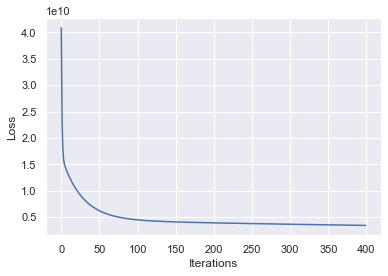

train accuracy R2 score =  0.4719134242786588
test accuracy R2 score =  0.3583210830881425


In [8]:
# run gradient descent algorithm 
tau = 0.000000001
w_init= np.ones(X.shape[1])[:,None]*0
max_iter = 400
w, L_iters, w_iters = grad_desc(X,y_train,w_init,tau,max_iter)

# plot
plt.figure(1)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
y_train_pred=f_pred(X,w)
train_score=score(y_train_pred,y_train)
print("train accuracy R2 score = ",train_score)

y_test_pred=f_pred(X_test,w)
test_score=score(y_test_pred,y_test)
print("test accuracy R2 score = ",test_score)

### Running linear regression with basic preprocessed features + Standardization. 
<br>Standardization is applied to continuous variables.

In [9]:
#Applying Standardization (Z-Score method)
continuous = ['LotArea', 'YearBuilt', 'YearRemodAdd', 
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
features_stand=train1.copy()
for i in continuous:
    # fit on training data column
    scale = StandardScaler().fit(train1[[i]])
    # transform training data column
    features_stand[i] = scale.transform(features_stand[[i]])
labels = train1['SalePrice']
features_stand.drop(['Id', 'SalePrice'], axis=1, inplace=True)

#split data
train_X_stan, test_X_stan, train_Y_stan, test_Y_stan = train_test_split(features_stand,labels,test_size=0.2, random_state=0)

# initialisation for training data
x_train_stan=train_X_stan.to_numpy()
y_train_stan=train_Y_stan.to_numpy()[:,None]
n_train_stan=x_train_stan.shape[0]
f_train_stan=x_train_stan.shape[1]
X_stan = np.ones([n_train_stan,f_train_stan+1]) 
X_stan[:,1:] = x_train_stan

# initialisation for test data 
x_test_stan=test_X_stan.to_numpy()
y_test_stan=test_Y_stan.to_numpy()[:,None]
n_test_stan=x_test_stan.shape[0]
f_test_stan=x_test_stan.shape[1]
X_test_stan = np.ones([n_test_stan,f_test_stan+1]) 
X_test_stan[:,1:] = x_test_stan

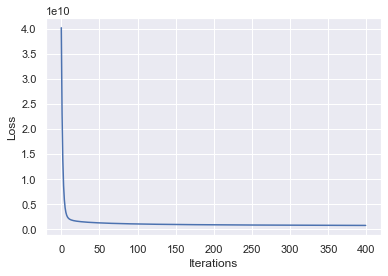

train accuracy R2 score =  0.8710083256757395
test accuracy R2 score =  0.6661078877244919


In [10]:
#run gradient descent algorithm 
tau = 0.01
w_init= np.ones(X.shape[1])[:,None]*0
max_iter = 400
w, L_iters, w_iters = grad_desc(X_stan,y_train_stan,w_init,tau,max_iter)

# plot
plt.figure(2)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
y_train_pred_stan=f_pred(X_stan,w)
train_score_stan=score(y_train_pred_stan,y_train_stan)
print("train accuracy R2 score = ",train_score_stan)

y_test_pred_stan=f_pred(X_test_stan,w)
test_score_stan=score(y_test_pred_stan,y_test_stan)
print("test accuracy R2 score = ",test_score_stan)


We then check if there is an improvement in accuracy after Z-score standardization

In [11]:
#improvement in accuracy
train_improvement = (train_score_stan - train_score)
test_improvement = (test_score_stan - test_score)
print ("Train accuracy improvement =", train_improvement,"%")
print ("Test accuracy improvement =", test_improvement,"%")

Train accuracy improvement = 0.3990949013970807 %
Test accuracy improvement = 0.30778680463634944 %


[back to top](#top)

## Reducing dimension: Feature selection <a class="anchor" id="feature"></a>
Feature selection is choosing data that is relevant or that are most helpful in training the model. This will increase accuracy by preventing the model from learning based on irrelevent features.
<br><br>
Also, reducing the number of features will allow the algorithm to run faster and help us to work within the limitations of memory space. This is most significant when we subsequently test the predictive functions with different polynomial degree.
<br><br>
In the later section, we want to test with predictive functions of different polynomial degree. Due to limited memory space, we would want to reduce the number of features. We will select features  that are correlated to SalePrice with an absolute value of more than 0.3.

In [12]:
# variables most closely related to SalePrice
corr = train1.corr()['SalePrice']
feature_select=[]
corrshape=corr.nlargest(corr.shape[0])[1:corr.shape[0]].shape[0]
for i in range(corrshape-1):
    if (corr.nlargest(corrshape)[1:corrshape][i])>0.3:
        feature_select.append(corr.nlargest(corrshape)[1:corrshape].axes[0][i])
print(corr.nlargest(corrshape)[1:corrshape])
print(len(feature_select))

GrLivArea            0.709783
GarageCars           0.636173
GarageArea           0.607197
TotalBsmtSF          0.603284
1stFlrSF             0.596087
                       ...   
OverallQual_5       -0.383080
GarageType_Detchd   -0.406550
BsmtQual_TA         -0.456964
GarageFinish_Unf    -0.485273
KitchenQual_TA      -0.527689
Name: SalePrice, Length: 246, dtype: float64
39


In [13]:
#train-test split
TEST_SIZE = 0.2

filteredData2 = train1.drop(['Id'], axis=1)[feature_select+['SalePrice']]
train_df2, test_df2 = train_test_split(filteredData2, test_size=TEST_SIZE)

train_X = train_df2.drop('SalePrice', axis=1)
train_Y = train_df2['SalePrice']
test_X = test_df2.drop('SalePrice', axis=1)
test_Y = test_df2['SalePrice']

# initialisation for training data
x_train=train_X.to_numpy()
y_train=train_Y.to_numpy()[:,None]
n_train=x_train.shape[0]
f_train=x_train.shape[1]
X = np.ones([n_train,f_train+1]) 
X[:,1:] = x_train

# initialisation for test data 
x_test=test_X.to_numpy()
y_test=test_Y.to_numpy()[:,None]
n_test=x_test.shape[0]
f_test=x_test.shape[1]
X_test = np.ones([n_test,f_test+1]) 
X_test[:,1:] = x_test

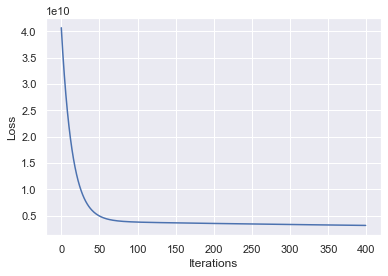

train accuracy R2 score =  0.4840244544292672
test accuracy R2 score =  0.3882779108879991


In [14]:
# run gradient descent algorithm 
tau = 0.000000001
w_init= np.ones(X.shape[1])[:,None]*0
max_iter = 400
w, L_iters, w_iters = grad_desc(X,y_train,w_init,tau,max_iter)

# plot
plt.figure(3)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
y_train_pred=f_pred(X,w)
train_score_fs=score(y_train_pred,y_train)
print("train accuracy R2 score = ",train_score_fs)

y_test_pred=f_pred(X_test,w)
test_score_fs=score(y_test_pred,y_test)
print("test accuracy R2 score = ",test_score_fs)

We then check if there is an improvement in accuracy after feature selection.

In [15]:
#improvement in accuracy
train_improvement = (train_score_fs - train_score)
test_improvement = (test_score_fs - test_score)
print ("Train accuracy improvement =", train_improvement,"%")
print ("Test accuracy improvement =", test_improvement,"%")

Train accuracy improvement = 0.012111030150608437 %
Test accuracy improvement = 0.029956827799856645 %


[back to top](#top)

## Hyperparameter Tuning 1 <a class="anchor" id="hyper1"></a>
We will now do some hyperparameter tuning to try and improve our results. This section will be on trial and error.

1. [Polynomial Degree](#poly)

### Polynomial Degree <a class="anchor" id="poly"></a>
Use different polynomial degree in gradient descent model for selected features

In [16]:
# List of values of the polynomial degree d
train_error_tab = np.zeros(3)
val_error_tab = np.zeros(3)

In [17]:
#Applying Standardization (Z-Score method)
continuous = ['LotArea', 'YearBuilt', 'YearRemodAdd', 
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
features_stand=train1.copy()
for i in continuous:
    # fit on training data column
    scale = StandardScaler().fit(train1[[i]])
    # transform training data column
    features_stand[i] = scale.transform(features_stand[[i]])
labels = train1['SalePrice']
features_stand.drop(['Id', 'SalePrice'], axis=1, inplace=True)
train_X_stan, test_X_stan, train_Y_stan, test_Y_stan = train_test_split(features_stand[feature_select],labels,test_size=0.2, random_state=0)

# initialisation for training data
x_train=train_X_stan.to_numpy()
y_train=train_Y_stan.to_numpy()[:,None]
n_train=x_train.shape[0]
f_train=x_train.shape[1]
X = np.ones([n_train,f_train+1]) 
X[:,1:] = x_train

# initialisation for test data 
x_test=test_X_stan.to_numpy()
y_test=test_Y_stan.to_numpy()[:,None]
n_test=x_test.shape[0]
f_test=x_test.shape[1]
X_test = np.ones([n_test,f_test+1]) 
X_test[:,1:] = x_test

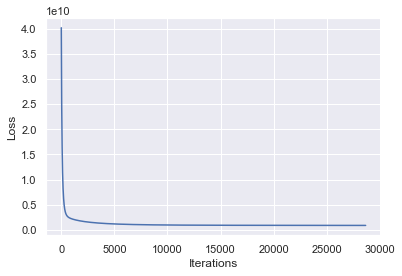

train accuracy R2 score =  0.8562162738006575
test accuracy R2 score =  0.6728062717044756


In [18]:
#Gradient descent with feature selection (threshold=0.3) with polynomial degree 1
tau = 0.001
w_init= np.ones(X.shape[1])[:,None]*0
max_iter = 50000
w, L_iters, w_iters = grad_desc(X,y_train,w_init,tau,max_iter)

# plot
plt.figure(4)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
train_error_tab[0]=L_iters[-1]
y_train_pred=f_pred(X,w)
train_score_d1=score(y_train_pred,y_train)
print("train accuracy R2 score = ",train_score_d1)

y_test_pred=f_pred(X_test,w)
test_loss = loss_mse(y_test_pred,y_test)
val_error_tab[0]=test_loss
test_score_d1=score(y_test_pred,y_test)
print("test accuracy R2 score = ",test_score_d1)

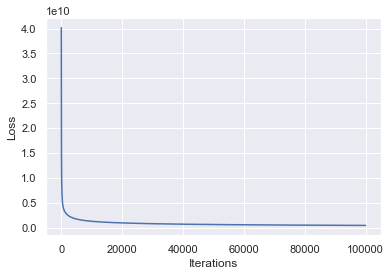

train accuracy R2 score =  0.9266219835253747
test accuracy R2 score =  0.818073308357503


In [19]:
#Gradient descent with feature selection (threshold=0.3) with polynomial degree 2
poly = PolynomialFeatures(2)
X_d2 = poly.fit_transform(x_train)
X_d2_test = poly.fit_transform(x_test)
tau = 0.0001
w_init= np.zeros([X_d2.shape[1]])[:,None]
max_iter = 100000
w, L_iters, w_iters = grad_desc(X_d2,y_train,w_init,tau,max_iter)

# plot
plt.figure(5)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
train_error_tab[1]=L_iters[-1]
y_train_pred=f_pred(X_d2,w)
train_score_d2=score(y_train_pred,y_train)
print("train accuracy R2 score = ",train_score_d2)

y_test_pred=f_pred(X_d2_test,w)
test_loss = loss_mse(y_test_pred,y_test)
val_error_tab[1]=test_loss
test_score_d2=score(y_test_pred,y_test)
print("test accuracy R2 score = ",test_score_d2)

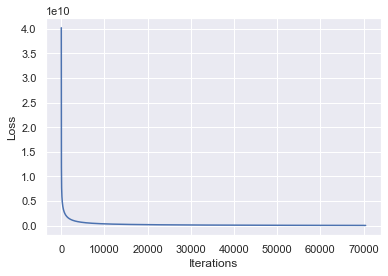

train accuracy R2 score =  0.9873617260719055
test accuracy R2 score =  -1.631551630809506


In [20]:
#Gradient descent with feature selection (threshold=0.3) with polynomial degree 3
poly = PolynomialFeatures(3)
X_d3 = poly.fit_transform(x_train)
X_d3_test = poly.fit_transform(x_test)
tau = 0.0001
w_init= np.zeros([X_d3.shape[1]])[:,None]
max_iter = 100000
w, L_iters, w_iters = grad_desc(X_d3,y_train,w_init,tau,max_iter)

# plot
plt.figure(6)
plt.plot(np.array(range(L_iters.shape[0])), L_iters)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

# calculating loss and accuracy
train_error_tab[2]=L_iters[-1]
y_train_pred=f_pred(X_d3,w)
train_score_d3=score(y_train_pred,y_train)
print("train accuracy R2 score = ",train_score_d3)

y_test_pred=f_pred(X_d3_test,w)
test_loss = loss_mse(y_test_pred,y_test)
val_error_tab[2]=test_loss
test_score_d3=score(y_test_pred,y_test)
print("test accuracy R2 score = ",test_score_d3)

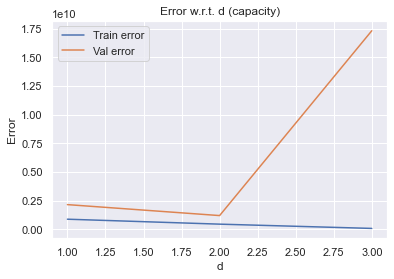

In [21]:
#Comparison of 3 different polynomial degree
x = [1,2,3]
plt.figure(1)
plt.plot(x, train_error_tab,label='Train error'.format(i=1))
plt.plot(x, val_error_tab,label='Val error'.format(i=2))
plt.legend(loc='best')
plt.title('Error w.r.t. d (capacity)')
plt.xlabel('d')
plt.ylabel('Error')
plt.show()

The better-performing model that is able to generalize well is the model with a polynomial of degree 2.

[back to top](#top)

## Regularization</a> <a class="anchor" id="reg"></a>
Here, we include regularisation in our updated gradient descent functions.

In [22]:
# Regularized regression loss
def loss_regreg(w,X,y,reg): 
    n = len(y)
    y_pred = X.dot(w) 
    loss = 1/n* (y_pred - y).T.dot(y_pred - y)
    d = w.shape[0]
    loss += reg/d * w.T.dot(w)
    return loss

# gradient function definition
def grad_loss(y_pred,y,X,w,reg):
    n = len(y)
    d = w.shape[0]
    grad = 2/n* X.T.dot(y_pred-y) + (2*reg/d)*w
    return grad

# gradient descent function definition
def grad_desc(X, y , w_init=np.zeros(X.shape[1])[:,None] ,tau=0.01,reg=0, max_iter=1000000,threshold=10**(3)):

    L_iters = np.zeros([max_iter]) # record the loss values
    w_iters = np.zeros([max_iter,X.shape[1]]) # record the loss values
    w = w_init # initialization
    break_condition=False
    for i in range(max_iter): # loop over the iterations
        y_pred = f_pred(X,w) # linear predicition function
        grad_f = grad_loss(y_pred,y,X,w,reg) # gradient of the loss 
        w = w - tau* grad_f # update rule of gradient descent 
        L_iters[i] = loss_regreg(w,X,y,reg) # save the current loss value 
        w_iters[i,:] = w.squeeze() # save the current w value 
        #stopping condition 1
        if i>0:
            if (abs(L_iters[i]-L_iters[i-1])< threshold):
                L_iters=L_iters[:i+1]
                w_iters=w_iters[:i+1,:]
                break_condition=True
        #stopping condition 2
        if score(y_pred,y)-score(f_pred(X,w_iters[i-1]),y)<0.05:
                L_iters=L_iters[:i+1]
                w_iters=w_iters[:i+1,:]
                break_condition=True
        if break_condition==True:
            break

    return w, L_iters, w_iters

def compute_w_solution(X,y,w_init,tau,reg, max_iter):
    initial_w = np.ones((X.shape[1],1))*w_init
    #gradient descent
    w, L_iters, w_iters = grad_desc(X, y , initial_w ,tau,reg, max_iter)
    loss_solution = L_iters[-1]
    return w, loss_solution

[back to top](#top)

## Hyperparameter Tuning 2 - With K-fold Cross Validation <a class="anchor" id="hyper2"></a>
Cross-validation is a statistical method used to estimate the skill of machine learning models.<br>
It is used here to help decide which hyperparameter shoud be used in the model to achieve a better result.<br><br>

The hyperparameters we will test are:
1. [Regularisation Parameter](#Kreg)
2. [Learning Rate](#Ktau)
3. [Initial w](#Kw)
<br>

[Results](#Kresults)

### Regulariation Parameter <a class="anchor" id="Kreg"></a>

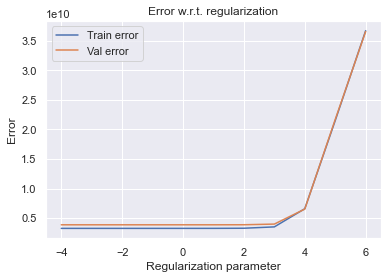

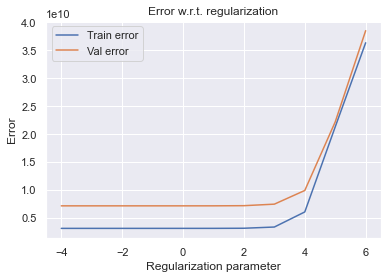

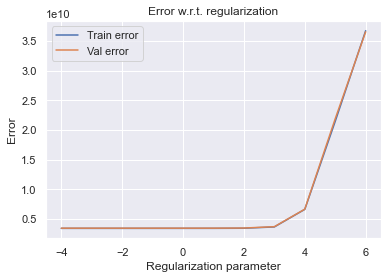

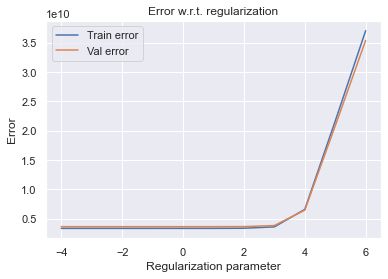

In [23]:
X=train_X_stan.to_numpy()
y=train_Y_stan.to_numpy()
kf = KFold(n_splits=4)
reg = np.array(range(-4,7),np.float32)
reg = 10**reg
list_reg = list(reg)
val_error_tab_tab = np.zeros([4,len(list_reg)])
k=0
for train_index, val_index  in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    #run algorithm for different hyperparameter

    d = 2
    poly = PolynomialFeatures(d)
    X_d2 = poly.fit_transform(X_train)
    X_val_d2 = poly.fit_transform(X_val)
    train_error_tab = np.zeros(len(list_reg))
    val_error_tab = np.zeros(len(list_reg))

    tau = 0.0001
    max_iter = 1000
    for i,reg in enumerate(list_reg):
        w, train_loss_solution = compute_w_solution(X_d2,y_train[:,None],0,tau,reg,max_iter)
        y_train_pred=f_pred(X_d2,w)
        train_error=loss_mse(y_train_pred,y_train[:,None])
        train_error_tab[i] = train_error
    
        y_val_pred=f_pred(X_val_d2,w)
        val_error=loss_mse(y_val_pred,y_val[:,None])
        val_error_tab[i] = val_error

    val_error_tab_tab[k]=val_error_tab
    k+=1
    # plot
    x = np.array(range(-4,7),np.float32)
    plt.figure(1)
    plt.plot(x, train_error_tab,label='Train error'.format(i=1))
    plt.plot(x, val_error_tab,label='Val error'.format(i=2))
    plt.legend(loc='best')
    plt.title('Error w.r.t. regularization')
    plt.xlabel('Regularization parameter')
    plt.ylabel('Error')
    plt.show()

#record Loss value for each hyperparameter
    
#after all iterations, calculate mean loss for each hyperparameter
    

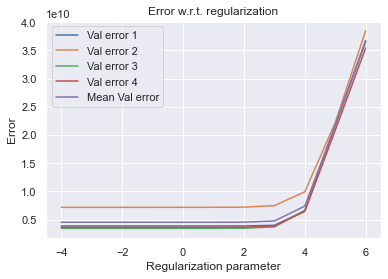

In [24]:
# plot
x = np.array(range(-4,7),np.float32)
plt.figure(1)
for k in range(kf.get_n_splits(X)):
    plt.plot(x, val_error_tab_tab[k],label=('Val error '+ str(k+1)) .format(i=(k+1)))

plt.plot(x, np.mean(val_error_tab_tab,axis=0),label='Mean Val error'.format(i=(k+1)))
plt.legend(loc='best')
plt.title('Error w.r.t. regularization')
plt.xlabel('Regularization parameter')
plt.ylabel('Error')
plt.show()

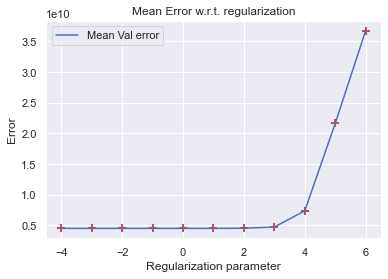

In [25]:
plt.figure(1)
plt.plot(x, np.mean(val_error_tab_tab,axis=0),label='Mean Val error'.format(i=1))
plt.scatter(x, np.mean(val_error_tab_tab,axis=0), s=60, c='r', marker='+', linewidths=2) 
plt.legend(loc='best')
plt.title('Mean Error w.r.t. regularization')
plt.xlabel('Regularization parameter')
plt.ylabel('Error')
plt.show()

[Hyperparameter Tuning 2](#hyper2) <br>
[back to top](#top)

### Learning Rate <a class="anchor" id="Ktau"></a>

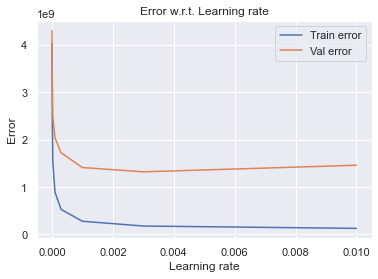

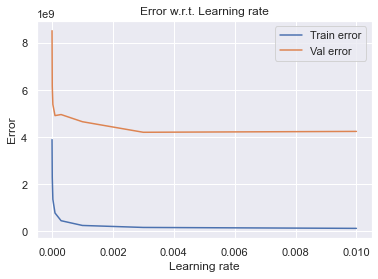

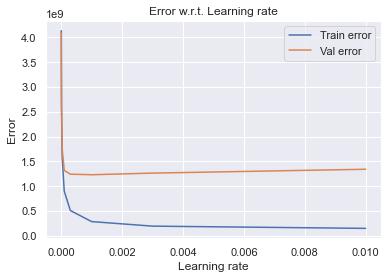

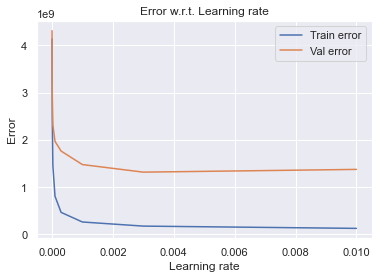

In [26]:
X=train_X_stan.to_numpy()
y=train_Y_stan.to_numpy()
kf = KFold(n_splits=4)

tau_list = [0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01]


val_error_tab_tab = np.zeros([kf.get_n_splits(X),len(tau_list)])
k=0

for train_index, val_index  in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    #run algorithm for different hyperparameter

    d = 2
    poly = PolynomialFeatures(d)
    X_d = poly.fit_transform(X_train)
    X_val_d = poly.fit_transform(X_val)
    train_error_tab = np.zeros(len(tau_list))
    val_error_tab = np.zeros(len(tau_list))

    reg=0
    max_iter = 20000
    for i,tau in enumerate(tau_list):
        w, train_loss_solution = compute_w_solution(X_d,y_train[:,None],0,tau,reg,max_iter)
        y_train_pred=f_pred(X_d,w)
        train_error=loss_mse(y_train_pred,y_train[:,None])
        train_error_tab[i] = train_error
    
        y_val_pred=f_pred(X_val_d,w)
        val_error=loss_mse(y_val_pred,y_val[:,None])
        val_error_tab[i] = val_error

    val_error_tab_tab[k]=val_error_tab
    k+=1
    
    # plot train error and val error
    x = [0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01]
    plt.figure(1)
    plt.plot(x, train_error_tab,label='Train error'.format(i=1))
    plt.plot(x, val_error_tab,label='Val error'.format(i=2))
    plt.legend(loc='best')
    plt.title('Error w.r.t. Learning rate')
    plt.xlabel('Learning rate')
    plt.ylabel('Error')
    plt.show()


    

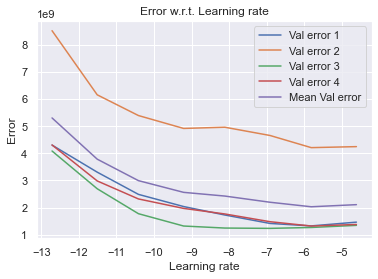

In [27]:
# plot
x = np.log([0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01])
plt.figure(1)
for k in range(kf.get_n_splits(X)):
    plt.plot(x, val_error_tab_tab[k],label=('Val error '+ str(k+1)) .format(i=(k+1)))

plt.plot(x, np.mean(val_error_tab_tab,axis=0),label='Mean Val error'.format(i=(k+1)))
plt.legend(loc='best')
plt.title('Error w.r.t. Learning rate')
plt.xlabel('Learning rate')
plt.ylabel('Error')
plt.show()

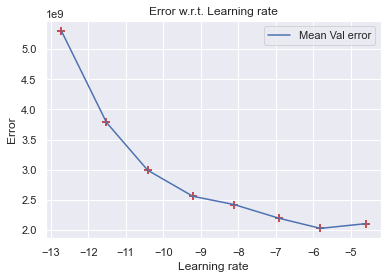

In [28]:
plt.figure(1)
plt.plot(x, np.mean(val_error_tab_tab,axis=0),label='Mean Val error'.format(i=1))
plt.scatter(x, np.mean(val_error_tab_tab,axis=0), s=60, c='r', marker='+', linewidths=2) 
plt.legend(loc='best')
plt.title('Error w.r.t. Learning rate')
plt.xlabel('Learning rate')
plt.ylabel('Error')
plt.show()

[Hyperparameter Tuning 2](#hyper2) <br>
[back to top](#top)

### Initial w <a class="anchor" id="Kw"></a>

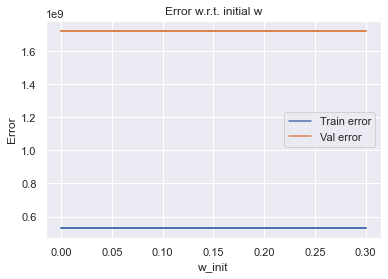

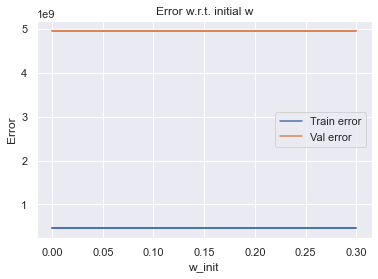

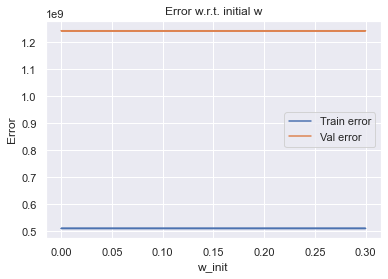

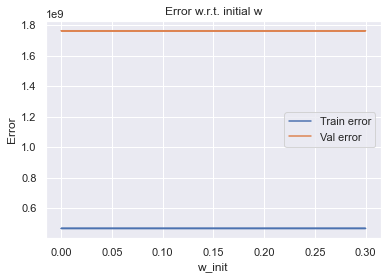

In [29]:
X=train_X_stan.to_numpy()
y=train_Y_stan.to_numpy()
kf = KFold(n_splits=4)

w_init_list = [0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 0]


val_error_tab_tab = np.zeros([kf.get_n_splits(X),len(w_init_list)])
k=0

for train_index, val_index  in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    #run algorithm for different hyperparameter

    d = 2
    poly = PolynomialFeatures(d)
    X_d = poly.fit_transform(X_train)
    X_val_d = poly.fit_transform(X_val)
    train_error_tab = np.zeros(len(w_init_list))
    val_error_tab = np.zeros(len(w_init_list))

    reg=0
    tau=0.0003
    max_iter = 20000
    for i,w_init in enumerate(w_init_list):
        w, train_loss_solution = compute_w_solution(X_d,y_train[:,None],w_init,tau,reg,max_iter)
        y_train_pred=f_pred(X_d,w)
        train_error=loss_mse(y_train_pred,y_train[:,None])
        train_error_tab[i] = train_error
    
        y_val_pred=f_pred(X_val_d,w)
        val_error=loss_mse(y_val_pred,y_val[:,None])
        val_error_tab[i] = val_error

    val_error_tab_tab[k]=val_error_tab
    k+=1
    
    # plot train error and val error
    x = [0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 0]
    plt.figure(1)
    plt.plot(x, train_error_tab,label='Train error'.format(i=1))
    plt.plot(x, val_error_tab,label='Val error'.format(i=2))
    plt.legend(loc='best')
    plt.title('Error w.r.t. initial w')
    plt.xlabel('w_init')
    plt.ylabel('Error')
    plt.show()


    

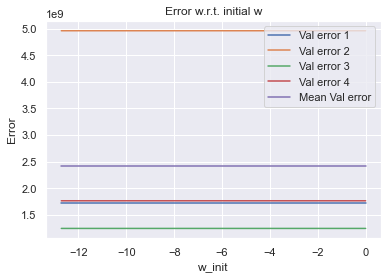

In [30]:
# plot
x = np.log([0.000003, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3])
x=np.concatenate((x,[0]))
plt.figure(1)
for k in range(kf.get_n_splits(X)):
    plt.plot(x, val_error_tab_tab[k],label=('Val error '+ str(k+1)) .format(i=(k+1)))

plt.plot(x, np.mean(val_error_tab_tab,axis=0),label='Mean Val error'.format(i=(k+1)))
plt.legend(loc='best')
plt.title('Error w.r.t. initial w')
plt.xlabel('w_init')
plt.ylabel('Error')
plt.show()

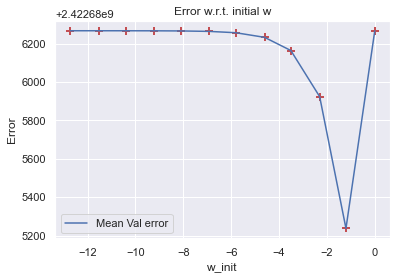

In [31]:
plt.figure(1)
plt.plot(x, np.mean(val_error_tab_tab,axis=0),label='Mean Val error'.format(i=1))
plt.scatter(x, np.mean(val_error_tab_tab,axis=0), s=60, c='r', marker='+', linewidths=2) 
plt.legend(loc='best')
plt.title('Error w.r.t. initial w')
plt.xlabel('w_init')
plt.ylabel('Error')
plt.show()

[Hyperparameter Tuning 2](#hyper2) <br>
[back to top](#top)

### Results <a class="anchor" id="Kresults"></a>
From the application of k-fold cross validation, we decided to use the following hyperparameters:<br>
1. Regularization = 0
2. Learning rate = 0.003
3. Initial w = 0.1

In [32]:
# initialisation for training data
x_train=train_X_stan.to_numpy()
y_train=train_Y_stan.to_numpy()[:,None]
n_train=x_train.shape[0]
f_train=x_train.shape[1]
X = np.ones([n_train,f_train+1]) 
X[:,1:] = x_train

# initialisation for test data 
x_test=test_X_stan.to_numpy()
y_test=test_Y_stan.to_numpy()[:,None]
n_test=x_test.shape[0]
f_test=x_test.shape[1]
X_test = np.ones([n_test,f_test+1]) 
X_test[:,1:] = x_test

poly = PolynomialFeatures(2)
X_d2 = poly.fit_transform(x_train)
X_d2_test = poly.fit_transform(x_test)

reg=0
tau=0.0003
w_init=0.1
max_iter = 100000
w, train_loss_solution = compute_w_solution(X_d2,y_train,w_init,tau,reg,max_iter)
y_train_pred=f_pred(X_d2,w)

# calculating loss and accuracy
y_train_pred=f_pred(X_d2,w)
train_score_best=score(y_train_pred,y_train)
print("train accuracy R2 score = ",train_score_best)

y_test_pred=f_pred(X_d2_test,w)
test_loss = loss_mse(y_test_pred,y_test)
test_score_best=score(y_test_pred,y_test)
print("test accuracy R2 score = ",test_score_best)

train accuracy R2 score =  0.9529289456917198
test accuracy R2 score =  0.8426659411112183


After submiting to Kaggle, it gave a score of 0.21016.

[back to top](#top)

## Advanced Optimisation Techniques  <a class="anchor" id="adv"></a>
The standard gradient descent technique presents a few challenges that need to be addressed.
<br>
1. Difficult to choose a proper learning rate
2. Gradient descent might get stuck in a local minimum for non-convex functions
<br>
Hence, we will test some advanced optimisation techniques to improve our results.

#### Import Dataset and Pre-processing

In [33]:
train = pd.read_csv('train.csv')

In [34]:
# remove null
nullData = [['LotFrontage', 259], ['MasVnrArea', 8], ['Electrical', 1], ['GarageYrBlt', 81]]
n = len(train)
treshold = 0.1
drop = []

print('Drop feature - too many nulls:')
for i in nullData:
    if i[1]/n > treshold: # Arbitrary treshold: 10%
        print(i[0])
        train.drop(columns=[i[0]], inplace=True)
    else:
        drop.append(i[0])
        
print('Remove data point:')
print(drop)
train.dropna(subset=drop, inplace=True)

Drop feature - too many nulls:
LotFrontage
Remove data point:
['MasVnrArea', 'Electrical', 'GarageYrBlt']


In [35]:
# train0

In [36]:
#One-Hot encoding
categoricalcolumns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
train0 = pd.get_dummies(train, columns= categoricalcolumns, prefix= categoricalcolumns)

y = train0['SalePrice']
X = train0.drop(['Id', 'SalePrice'], axis=1)

train_X0, test_X0, train_Y0, test_Y0 = train_test_split(X,y,test_size=0.2, random_state=0)

In [37]:
# train1

In [38]:
categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
#skewness of categorical variables
max_percent = []
catogorical_skewed=[]
for i in categorical: 
    if rp.summary_cat(train[i])["Percent"].max() >= 90: 
        max_percent.append(rp.summary_cat(train[i])["Percent"].max())
print ("The number of variables with one category of data which occupies >= 90% of data =", len(max_percent))
#highly skewed categorical variables
for i in categorical: 
    if rp.summary_cat(train[i])["Percent"].max() >= 90:
        catogorical_skewed.append(i)
        print (i,"/ratio of the dominant category = ", rp.summary_cat(train[i])["Percent"].max()/100)

The number of variables with one category of data which occupies >= 90% of data = 15
Street /ratio of the dominant category =  0.9964
LandContour /ratio of the dominant category =  0.9015000000000001
Utilities /ratio of the dominant category =  0.9993000000000001
LandSlope /ratio of the dominant category =  0.9467
Condition2 /ratio of the dominant category =  0.9898
RoofMatl /ratio of the dominant category =  0.9818000000000001
BsmtCond /ratio of the dominant category =  0.9246
Heating /ratio of the dominant category =  0.981
CentralAir /ratio of the dominant category =  0.9495999999999999
Electrical /ratio of the dominant category =  0.9226000000000001
Functional /ratio of the dominant category =  0.9336
GarageQual /ratio of the dominant category =  0.9504
GarageCond /ratio of the dominant category =  0.9612999999999999
PavedDrive /ratio of the dominant category =  0.9372
MiscFeature /ratio of the dominant category =  0.9216


In [39]:
for i in catogorical_skewed:
    train.drop(columns=[i], inplace=True)

In [40]:
for i in catogorical_skewed:
    categorical.remove(i)
#skewness of categorical variables
max_percent = []
for i in categorical: 
    if rp.summary_cat(train[i])["Percent"].max() >= 90: 
        max_percent.append(rp.summary_cat(train[i])["Percent"].max())
print ("The number of variables with one category of data which occupies >= 90% of data =", len(max_percent))
#highly skewed categorical variables
for i in categorical: 
    if rp.summary_cat(train[i])["Percent"].max() >= 90: 
         print (i,"/ratio of the dominant category = ", rp.summary_cat(train[i])["Percent"].max()/100)

The number of variables with one category of data which occupies >= 90% of data = 0


In [41]:
#One Hot Encoding
train1 = pd.get_dummies(train, columns= categorical, prefix= categorical)
train1.head()

,Id,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,8450,2003,2003,196.0,706,0,150,856,856,...,0,0,0,1,0,0,0,0,1,0
1,2,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,0,0,1,0,0,0,0,1,0
2,3,11250,2001,2002,162.0,486,0,434,920,920,...,0,0,0,1,0,0,0,0,1,0
3,4,9550,1915,1970,0.0,216,0,540,756,961,...,0,0,0,1,1,0,0,0,0,0
4,5,14260,2000,2000,350.0,655,0,490,1145,1145,...,0,0,0,1,0,0,0,0,1,0


In [42]:
# identifying continuous variables with high skewness
continuous = ['LotArea', 'YearBuilt', 'YearRemodAdd', 
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd', 'Fireplaces', 
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
array1 = skew(train1[continuous])
#the top 15 features which are the most skewed
index1 = array1.argsort()[-15:][::-1]
continuous_skewed=[]
for i in index1:
    print (continuous[i],": skewness = ", array1[i])
    if array1[i]>=1:
        continuous_skewed.append(continuous[i])

MiscVal : skewness =  24.732979451706033
PoolArea : skewness =  14.342881566937836
LotArea : skewness =  12.025446327344339
LowQualFinSF : skewness =  10.66505349858299
3SsnPorch : skewness =  9.96262046395852
KitchenAbvGr : skewness =  5.129053439295553
BsmtFinSF2 : skewness =  4.174330005566947
ScreenPorch : skewness =  3.967379533802487
BsmtHalfBath : skewness =  3.89811918894981
EnclosedPorch : skewness =  3.214887613130617
MasVnrArea : skewness =  2.588332838278803
OpenPorchSF : skewness =  2.2638025759950504
BsmtFinSF1 : skewness =  1.6941364533315026
TotalBsmtSF : skewness =  1.6330286577439608
WoodDeckSF : skewness =  1.5027101898713007


In [43]:
print('train1 shape\t\t:',train1.shape)
# calculate interquartile range
q25, q75 = train1[continuous_skewed].quantile(0.25), train1[continuous_skewed].quantile(0.75)
iqr = q75 - q25
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

train1_iqr = train1[~((train1>upper)).any(axis=1)]
print('train1_iqr shape\t:', train1_iqr.shape)

train1 shape		: (1370, 248)
train1_iqr shape	: (688, 248)


In [44]:
#calculating skewness of continuous variables
array = skew(train1_iqr[continuous])
#the top 3 features which are the most skewed
print('Top 3 features which are the most skewed:')
index = array.argsort()[-3:][::-1]
for i in index: 
    print (continuous[i],": skewness = ", array[i])

Top 3 features which are the most skewed:
MasVnrArea : skewness =  1.1633497486834365
OpenPorchSF : skewness =  1.0088075868431694
WoodDeckSF : skewness =  0.77571907189836


In [45]:
# variables most closely related to SalePrice
corr = train1_iqr.corr()['SalePrice']
# print(corr)
feature_select=[]
corrshape=corr.nlargest(corr.shape[0])[1:corr.shape[0]].shape[0]
# print(corrshape)
for i in range(corrshape-1):
    if (abs(corr.nlargest(corrshape)[1:corrshape][i])>0.2):
        feature_select.append(corr.nlargest(corrshape)[1:corrshape].axes[0][i])
        
print('Number of features selected = ', len(feature_select))        
print(corr.nlargest(corrshape)[1:corrshape])

train1 = train1_iqr[feature_select+['Id', 'SalePrice']]

Number of features selected =  73
GrLivArea            0.764786
GarageCars           0.699105
GarageArea           0.671034
TotRmsAbvGrd         0.639797
FullBath             0.632455
                       ...   
GarageType_Detchd   -0.452965
Foundation_CBlock   -0.478446
BsmtQual_TA         -0.527170
GarageFinish_Unf    -0.544653
KitchenQual_TA      -0.571333
Name: SalePrice, Length: 211, dtype: float64


In [46]:
y = train1['SalePrice']
X = train1.drop(['Id', 'SalePrice'], axis=1)

train_X1, test_X1, train_Y1, test_Y1 = train_test_split(X,y,test_size=0.2, random_state=0)

[back to top](#top)

### Keras TensorFlow <a class="anchor" id="keras"></a>

Tensorflow is an open-source library for machine learning, while Keras is a neural-networks library that runs on top of Tensorflow. Keras has optimizers built in to the functions, such as Adam, Adamax, Adadelta, Nadam, and FTLR (Follow the Regularized Leader).
<br><br>
For the sake of simplicity, we will create a single layer neural network (normal gradient descent) and train the model with __Nadam__ (as it gives us the best results). We also tried training with and without pre-processing on the train dataset.
<br><br>
Upon inspection of the R2 score, using these optimizers on a single layer of gradient descent does not give us good results.

#### Adam <a class="anchor" id="kerasadam"></a>

__No Preprocessing__

In [47]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(train_X0.shape[1])))
model.add(tf.keras.layers.Dense(1, activation='relu'))
opt = keras.optimizers.Adam()
model.compile(opt, loss='mse')
model.fit(train_X0, train_Y0)

35/35 [==============================] - 0s 469us/step - loss: 40166547683.5556


In [48]:
y_pred = model.predict(train_X0)
print('Train R2 score\t:', r2_score(train_Y0, np.squeeze(y_pred)))

y_pred = model.predict(test_X0)
print('Test R2 score\t:', r2_score(test_Y0, np.squeeze(y_pred)))

Train R2 score	: -5.4868960945954
Test R2 score	: -5.311916805891069


__With Preprocessing__

In [49]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(train_X1.shape[1])))
model.add(tf.keras.layers.Dense(1, activation='relu'))
opt = keras.optimizers.Adam()
model.compile(opt, loss='mse')
model.fit(train_X1, train_Y1)

18/18 [==============================] - 0s 528us/step - loss: 37737693184.0000


In [50]:
y_pred = model.predict(train_X1)
print('Train R2 score\t:', r2_score(train_Y1, np.squeeze(y_pred)))

y_pred = model.predict(test_X1)
print('Test R2 score\t:', r2_score(test_Y1, np.squeeze(y_pred)))

Train R2 score	: -7.259138535575959
Test R2 score	: -7.63249987047754


#### Nadam <a class="anchor" id="kerasnadam"></a>

__No Preprocessing__

In [51]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(train_X0.shape[1])))
model.add(tf.keras.layers.Dense(1, activation='relu'))
opt = keras.optimizers.Nadam()
model.compile(opt, loss='mse')
model.fit(train_X0, train_Y0)

35/35 [==============================] - 0s 469us/step - loss: 39988467143.1111


In [52]:
y_pred = model.predict(train_X0)
print('Train R2 score\t:', r2_score(train_Y0, np.squeeze(y_pred)))

y_pred = model.predict(test_X0)
print('Test R2 score\t:', r2_score(test_Y0, np.squeeze(y_pred)))

Train R2 score	: -5.553225387570012
Test R2 score	: -5.3753833881067


__With Preprocessing__

In [53]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(train_X1.shape[1])))
model.add(tf.keras.layers.Dense(1, activation='relu'))
opt = keras.optimizers.Nadam()
model.compile(opt, loss='mse')
model.fit(train_X1, train_Y1)

18/18 [==============================] - 0s 528us/step - loss: 36957155759.1579


In [54]:
y_pred = model.predict(train_X1)
print('Train R2 score\t:', r2_score(train_Y1, np.squeeze(y_pred)))

y_pred = model.predict(test_X1)
print('Test R2 score\t:', r2_score(test_Y1, np.squeeze(y_pred)))

Train R2 score	: -7.259138535575959
Test R2 score	: -7.63249987047754


[back to top](#top)

### MLP Regressor <a class="anchor" id="mlp"></a>
SciKit Learn has neural-network modules that can be tuned using certain optimization techniques, namely LBFGS, Adam, and Stochastic Gradient Descent (SGD). We will try the optimization techniques on multiples hidden layers using SciKit Learn.

#### Adam <a class="anchor" id="SKadam"></a>

__No Preprocessing__

In [55]:
test_r2 = []
for i in range(10):
    mlp = MLPRegressor(random_state=i, solver='adam', max_iter=10000, early_stopping=True)
    mlp.fit(train_X0, train_Y0)
    pred_train = mlp.predict(train_X0)
    pred_test = mlp.predict(test_X0)
    print('Random state =', i, 'Train R2 =', r2_score(train_Y0, pred_train), 'Test R2 =', r2_score(test_Y0, pred_test)) ######
    test_r2.append(r2_score(test_Y0, pred_test))

Random state = 0 Train R2 = 0.7295460469776351 Test R2 = 0.45046427765185626
Random state = 1 Train R2 = 0.7277783756888095 Test R2 = 0.48091148271190154
Random state = 2 Train R2 = 0.6953451716997927 Test R2 = 0.5174298602736237
Random state = 3 Train R2 = 0.7262295211694022 Test R2 = 0.49965730564788113
Random state = 4 Train R2 = 0.7322077171278982 Test R2 = 0.5001234281344361
Random state = 5 Train R2 = -0.33102801775673885 Test R2 = -0.38831696502427127
Random state = 6 Train R2 = 0.7660216026964433 Test R2 = 0.45277642704334065
Random state = 7 Train R2 = 0.7242219904256835 Test R2 = 0.47975200950713603
Random state = 8 Train R2 = 0.7621370635925312 Test R2 = 0.40302540637144224
Random state = 9 Train R2 = 0.7320497456435788 Test R2 = 0.5184876559538352


In [56]:
print('Max test R2 score is :', max(test_r2))
print('Random state :', test_r2.index(max(test_r2)))

Max test R2 score is : 0.5184876559538352
Random state : 9


__With Preprocessing__

In [57]:
test_r2 = []
for i in range(10):
    mlp = MLPRegressor(random_state=i, solver='adam', max_iter=10000, early_stopping=True)
    mlp.fit(train_X1, train_Y1)
    pred_train = mlp.predict(train_X1)
    pred_test = mlp.predict(test_X1)
    print('Random state =', i, 'Train R2 =', r2_score(train_Y1, pred_train), 'Test R2 =', r2_score(test_Y1, pred_test)) ######
    test_r2.append(r2_score(test_Y1, pred_test))

Random state = 0 Train R2 = 0.4041174117579651 Test R2 = 0.4541227207092642
Random state = 1 Train R2 = 0.3739142597027786 Test R2 = 0.4059487949701295
Random state = 2 Train R2 = 0.39556595943164585 Test R2 = 0.43577198988770893
Random state = 3 Train R2 = 0.7655894019156126 Test R2 = 0.7675563686791909
Random state = 4 Train R2 = 0.8020892669821695 Test R2 = 0.7974577823327935
Random state = 5 Train R2 = 0.7475195741227859 Test R2 = 0.7462712862670211
Random state = 6 Train R2 = 0.7925170401882152 Test R2 = 0.7990028472411328
Random state = 7 Train R2 = 0.8015530085851944 Test R2 = 0.7953782035774359
Random state = 8 Train R2 = 0.31366043922753895 Test R2 = 0.3050291286705985
Random state = 9 Train R2 = 0.37969430884904587 Test R2 = 0.40910835812043844


In [58]:
print('Max test R2 score is :', max(test_r2))
print('Random state :', test_r2.index(max(test_r2)))

Max test R2 score is : 0.7990028472411328
Random state : 6


#### Limited-memory BFGS (LBFGS) <a class="anchor" id="SKLBFGS"></a>
For smaller datasets, LBFGS is supposed to be faster and better than Adam, which is more suited for large datasets with thousands of data.

We ran the algorithm on the bare dataset, and then tried some pre-processing on the data. From the test and train scores, on average, LBFGS does indeed perform better than Adam for this dataset. 

__No Preprocessing__

In [59]:
test_r2 = []
for i in range(10):
    mlp = MLPRegressor(random_state=i, solver='lbfgs', max_iter=50000, early_stopping=True)
    mlp.fit(train_X0, train_Y0)
    pred_train = mlp.predict(train_X0)
    pred_test = mlp.predict(test_X0)
    print('Random state =', i, 'Train R2 =', r2_score(train_Y0, pred_train), 'Test R2 =', r2_score(test_Y0, pred_test)) ######
    test_r2.append(r2_score(test_Y0, pred_test))

Random state = 0 Train R2 = 0.8196565348083416 Test R2 = -0.03529571165401468


C:\Users\tanji\miniconda3\envs\CE9010_2021\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Random state = 1 Train R2 = 0.9362506767530632 Test R2 = 0.7518207919247397
Random state = 2 Train R2 = 0.7803377890816092 Test R2 = 0.4972372411355507
Random state = 3 Train R2 = 0.8316435243992633 Test R2 = -0.0577674816854139
Random state = 4 Train R2 = 0.897840331017886 Test R2 = 0.4648855911338662
Random state = 5 Train R2 = 0.8664121785354008 Test R2 = 0.7160197415663396
Random state = 6 Train R2 = 0.8600622503727747 Test R2 = 0.5208138096883972
Random state = 7 Train R2 = 0.7597665829483498 Test R2 = 0.4292088269015576
Random state = 8 Train R2 = 0.7983522648516626 Test R2 = 0.21531708616833767
Random state = 9 Train R2 = 0.9386955840146336 Test R2 = -2.2222209732686973


C:\Users\tanji\miniconda3\envs\CE9010_2021\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [60]:
print('Max test R2 score is :', max(test_r2))
print('Random state :', test_r2.index(max(test_r2)))

Max test R2 score is : 0.7518207919247397
Random state : 1


__With Preprocessing__

In [61]:
test_r2 = []
for i in range(10):
    mlp = MLPRegressor(random_state=i, solver='lbfgs', max_iter=10000, early_stopping=True)
    mlp.fit(train_X1, train_Y1)
    pred_train = mlp.predict(train_X1)
    pred_test = mlp.predict(test_X1)
    print('Random state =', i, 'Train R2 =', r2_score(train_Y1, pred_train), 'Test R2 =', r2_score(test_Y1, pred_test)) ######
    test_r2.append(r2_score(test_Y1, pred_test))

Random state = 0 Train R2 = 0.8585814496925998 Test R2 = 0.7841820038496041
Random state = 1 Train R2 = 0.8346116486789318 Test R2 = 0.7983318757338801
Random state = 2 Train R2 = 0.875284998018678 Test R2 = 0.8125852810508406
Random state = 3 Train R2 = 0.8543923630029546 Test R2 = 0.7967433157622898
Random state = 4 Train R2 = 0.877812436128922 Test R2 = 0.8138165121282452
Random state = 5 Train R2 = 0.8588141576478324 Test R2 = 0.7917937337522976
Random state = 6 Train R2 = 0.8647644620111867 Test R2 = 0.8150866990452159
Random state = 7 Train R2 = 0.8921768802744736 Test R2 = 0.7901774601721898
Random state = 8 Train R2 = 0.893883957079942 Test R2 = 0.7565963607291907
Random state = 9 Train R2 = 0.8838628358634898 Test R2 = 0.8042844412059257


In [62]:
print('Max test R2 score is :', max(test_r2))
print('Random state :', test_r2.index(max(test_r2)))

Max test R2 score is : 0.8150866990452159
Random state : 6


[back to top](#top)

### Submitting to Kaggle <a class="anchor" id="submit"></a>

In [63]:
test = pd.read_csv('test.csv')

In [64]:
# One Hot Encoding

categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond','Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

test = pd.get_dummies(test, columns= categorical, prefix= categorical)

Id = test['Id']

col = list(train1.columns)
col.remove('SalePrice')
col.remove('Id')
test1 = test[col]
test1

,GrLivArea,GarageCars,GarageArea,TotRmsAbvGrd,FullBath,TotalBsmtSF,1stFlrSF,YearBuilt,Foundation_PConc,YearRemodAdd,...,OverallQual_4,MSZoning_RM,MasVnrType_None,OverallQual_5,HeatingQC_TA,GarageType_Detchd,Foundation_CBlock,BsmtQual_TA,GarageFinish_Unf,KitchenQual_TA
0,896,1.0,730.0,5,1,882.0,896,1961,0,1961,...,0,0,1,1,1,0,1,1,1,1
1,1329,1.0,312.0,6,1,1329.0,1329,1958,0,1958,...,0,0,0,0,1,0,1,1,1,0
2,1629,2.0,482.0,6,2,928.0,928,1997,1,1998,...,0,0,1,1,0,0,0,0,0,1
3,1604,2.0,470.0,7,2,926.0,926,1998,1,1998,...,0,0,0,0,0,0,0,1,0,0
4,1280,2.0,506.0,5,2,1280.0,1280,1992,1,1992,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1092,0.0,0.0,5,1,546.0,546,1970,0,1970,...,1,1,1,0,0,0,1,1,0,1
1455,1092,1.0,286.0,6,1,546.0,546,1970,0,1970,...,1,1,1,0,1,0,1,1,1,1
1456,1224,2.0,576.0,7,1,1224.0,1224,1960,0,1996,...,0,0,1,1,0,1,1,1,1,1
1457,970,0.0,0.0,6,1,912.0,970,1992,1,1992,...,0,0,1,1,1,0,0,0,0,1


In [65]:
print('Continuous data with NA to be filled')
for index in test1:
    if test1[index].isna().sum() != 0 :
        print(index)
        mean = test1[index].mean()
        test1[index] = test1[index].fillna(mean)

Continuous data with NA to be filled
GarageCars
GarageArea
TotalBsmtSF
GarageYrBlt
MasVnrArea
BsmtFinSF1
BsmtUnfSF
BsmtFullBath


C:\Users\tanji\miniconda3\envs\CE9010_2021\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


From the training data, we choose the best performing model:


In [66]:
# sklearn, LBFGS, on pre-processed data, random state = best state
mlp = MLPRegressor(random_state=test_r2.index(max(test_r2)), solver='lbfgs', max_iter=10000, early_stopping=True)
mlp.fit(train_X1, train_Y1)

# make prediction on test
pred = mlp.predict(test1)
pred

array([138681.33809087, 197751.01487559, 199885.96461899, ...,
       203724.54435943, 110513.53391889, 245717.23278695])

In [67]:
submit = pd.DataFrame(columns=['SalePrice'], data=pred)
submit.insert(0, 'Id', Id)
submit.head()
submit.to_csv('submit.csv', index=False)

Kaggle score was 0.28088

[back to top](#top)